<a href="https://colab.research.google.com/github/Ina0221/Automatic-Tic-Detection/blob/main/master_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Download all libraries needed

In [ ]:
#clean environment
from IPython import get_ipython
get_ipython().magic('reset -sf')

#import needed packages
import h5py
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import math
import os
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from sklearn import preprocessing as pre
import cv2
import os
import shutil
import glob

# Get the data 1: sleap file from drive

*   Mount with google drive to access your data
*   file ID for file: right mouse click on file in drive directory > copy Link > long number after 'open?id=' is the file ID





In [ ]:
# # BS:

# # Install the gdown library if not already installed
# !pip install gdown

# # Specify the Google Drive folder URL
# folder_url = 'https://drive.google.com/drive/folders/1ino_gvN4pY41L3ajQt6S_IpUMQc3OoZh?usp=sharing'

# # Extract the folder ID from the URL
# folder_id = folder_url.split('/')[-1]

# # Define the destination folder in your Colab environment
# destination_folder = '/content/drive/My Drive/Colab Notebookds/'

# # Use gdown to list files in the shared folder
# import gdown

# # List files and folders in the shared folder
# def list_files_in_folder(folder_id, destination_folder):
#     gdown.download(f'https://drive.google.com/uc?id={folder_id}', output=destination_folder, quiet=False)

# list_files_in_folder(folder_id, destination_folder)

In [ ]:
# # BS:

# !pip install gdown pydrive

# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive

# # Authenticate and create a GoogleDrive instance
# gauth = GoogleAuth()
# gauth.LocalWebserverAuth()  # This creates a local webserver and automatically handles authentication.
# drive = GoogleDrive(gauth)

# # Replace 'YOUR_FOLDER_LINK' with the shared folder link
# folder_link = 'https://drive.google.com/drive/folders/1ino_gvN4pY41L3ajQt6S_IpUMQc3OoZh?usp=sharing'

# # Define the destination folder in your Colab environment
# destination_folder = '/content/drive/My Drive/Colab Notebooks/'

# # Get the folder ID from the folder link
# folder_id = folder_link.split('/')[-1]

# # List files in the folder
# file_list = drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false"}).GetList()

# # Download each file in the folder
# for file in file_list:
#     file.GetContentFile(destination_folder + file['title'])

# print("Files downloaded successfully.")


In [ ]:
import pandas as pd
import requests
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# File URL from Google Drive
#ID for sleap data set
# File IDs
file_id = '1-QYfdGkczJmlUw8bG8K1nQJ6tRp1fZmy'
file_id_video = '1LZJEyJl38sOovVRZcpofdjdG7vTS3xbW'

# Construct the URLs for direct download
url = f'https://drive.google.com/uc?id={file_id}'
url_video = f'https://drive.google.com/uc?id={file_id_video}'

response = requests.get(url)
response_video = requests.get(url_video)

filename = '/content/drive/My Drive/datafile.h5'
video_file = '/content/drive/My Drive/video_file.mpg'

# Save downloaded files
with open(filename, 'wb') as f:
    f.write(response.content)

with open(video_file, 'wb') as v:
    v.write(response_video.content)



Mounted at /content/drive


#Get the data 2: Read the CSV file (manual scores)
CSV file is loaded in colab environment, since drive access does not work for this file

In [ ]:
import pandas as pd

# Provide the local path to the uploaded file
uploaded_file_path = '/content/drive/MyDrive/Colab Notebooks/Rat_231_0711_perfect.csv'  # Replace with the actual file name

# Define column names
column_names = ['frames', 'Unnamed: 0', 'Trial_time', 'Recording_time', 'Subject', 'Markings', 'State', 'Rat#',
                'Trial#', 'Intensity', 'Tic_length', 'pre_Tic_pause', 'post_Tic_pause', 'Time', 'Stand_Time', 'Plot',
                'orig_Tic_length', 'frame', 'event']

# Read CSV file
manual_file = pd.DataFrame(pd.read_csv(uploaded_file_path, sep=',', names=column_names))


#extract data from SLEAP file


In [ ]:
#--------------------------make a fucntion for easy use-----------------------------------------------------------------------
#--------------------------retrieve datafile adn roughly check on content-----------------------------------------------------

def make_dataframes(filename):

    with h5py.File(filename, "r") as f:
        dset_names = list(f.keys())
        locations = f["tracks"][:].T
        node_names = [n.decode() for n in f["node_names"][:]]

    frame_count, node_count, _, instance_count = locations.shape


    #-----------------------------------intrapolation of missing data (sleap.ai)---------------------------------------------

    from scipy.interpolate import interp1d

    def fill_missing(Y, kind="linear"):
        """Fills missing values independently along each dimension after the first."""

        # Store initial shape.
        initial_shape = Y.shape

        # Flatten after first dim.
        Y = Y.reshape((initial_shape[0], -1))

        # Interpolate along each slice.
        for i in range(Y.shape[-1]):
            y = Y[:, i]

            # Build interpolant.
            x = np.flatnonzero(~np.isnan(y))
            f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

            # Fill missing
            xq = np.flatnonzero(np.isnan(y))
            y[xq] = f(xq)

            # Fill leading or trailing NaNs with the nearest non-NaN values
            mask = np.isnan(y)
            y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

            # Save slice
            Y[:, i] = y

        # Restore to initial shape.
        Y = Y.reshape(initial_shape)

        return Y

    locations = fill_missing(locations)


    #------------------------------------------------define different body parts -----------------------------------------------

    NOSE_INDEX = 0
    LEFT_INDEX = 1
    RIGHT_INDEX = 2
    CENTER_INDEX = 3


    nose_loc = locations[:, NOSE_INDEX, :, :]
    left_loc = locations[:, LEFT_INDEX, :, :]
    right_loc = locations[:, RIGHT_INDEX, :, :]
    center_loc = locations[:, CENTER_INDEX, :, :]


    #------------------------------------calcualte velocity of body parts (sleap.ai)----------------------------------------------

    from scipy.signal import savgol_filter

    def smooth_diff(node_loc, win=25, poly=3):
        """
        node_loc is a [frames, 2] array

        win defines the window to smooth over

        poly defines the order of the polynomial
        to fit with

        """
        node_loc_vel = np.zeros_like(node_loc)

        for c in range(node_loc.shape[-1]):
            node_loc_vel[:, c] = savgol_filter(node_loc[:, c], win, poly, deriv=1)

        node_vel = np.linalg.norm(node_loc_vel,axis=1)

        return node_vel

    vel_nose = smooth_diff(nose_loc[:, :, 0])
    vel_right = smooth_diff(right_loc[:, :, 0])
    vel_left = smooth_diff(left_loc[:, :, 0])
    vel_center = smooth_diff(center_loc[:, :, 0])

    #----------------------------------Dataframe for velocities-----------------------------------------------------------------
    nose_velocity = pd.DataFrame(vel_nose, columns = ['velocity nose'])

    center_velocity = pd.DataFrame(vel_center, columns = ['velocity center'])

    right_velocity = pd.DataFrame(vel_right, columns = ['velocity right'])

    left_velocity = pd.DataFrame(vel_left, columns = ['velocity left'])

    #--------------------------put locations,velocities, accelerations and ratios in dataframe and then excel sheet--------------
    #x – The horizontal pixel location of point within image frame.
    #y – The vertical pixel location of point within image frame.

    #empty dataframe
    CN = ['frame']
    df_body_parts = pd.DataFrame(columns = CN)

    #extract datapoints
    frame = np.array((range(0,nose_loc.shape[0])))
    nosex = nose_loc[:,0,0]
    nosey = nose_loc[:,1,0]

    rightx = right_loc[:,0,0]
    righty = right_loc[:,1,0]

    leftx = left_loc[:,0,0]
    lefty = left_loc[:,1,0]

    centerx = center_loc[:,0,0]
    centery = center_loc[:,1,0]

    #add to frame
    df_body_parts['frame'] = frame.tolist()
    df_body_parts['x-nose'] = nosex.tolist()
    df_body_parts['y-nose'] = nosey.tolist()

    df_body_parts['x-right'] = rightx.tolist()
    df_body_parts['y-right'] = righty.tolist()

    df_body_parts['x-left'] = leftx.tolist()
    df_body_parts['y-left'] = lefty.tolist()

    df_body_parts['x-center'] = centerx.tolist()
    df_body_parts['y-center'] = centery.tolist()


    df_body_parts


#####-------------------------check wether all four points move and go along short axis------------------------------------

    def along_ears_axis(df_body_parts):

        def angle_between_vectors(vector1, vector2):
            vector1 = np.array(vector1)
            vector2 = np.array(vector2)
            dot_product = np.dot(vector1, vector2)
            magnitude1 = np.linalg.norm(vector1)
            magnitude2 = np.linalg.norm(vector2)
            angle_radians = np.arccos(dot_product / (magnitude1 * magnitude2))
            angle_degrees = np.degrees(angle_radians)
            return angle_degrees

        def are_points_in_same_direction(nose_initial, center_initial, left_initial, right_initial,
                                         nose_after, center_after, left_after, right_after,
                                         tolerance):
            nose_initial = np.array(nose_initial)
            center_initial = np.array(center_initial)
            left_initial = np.array(left_initial)
            right_initial = np.array(right_initial)

            nose_after = np.array(nose_after)
            center_after = np.array(center_after)
            left_after = np.array(left_after)
            right_after = np.array(right_after)

            vector1 = nose_after - nose_initial
            vector2 = center_after - center_initial
            vector3 = left_after - left_initial
            vector4 = right_after - right_initial

            angle12 = angle_between_vectors(vector1, vector2)
            angle23 = angle_between_vectors(vector2, vector3)
            angle34 = angle_between_vectors(vector3, vector4)

            angles = [angle12, angle23, angle34]
            avg_angle = sum(angles) / len(angles)
            for angle in angles:
                if abs(angle - avg_angle) > tolerance:
                    return False
            return True

        def direction_between_points(point1, point2):
            direction_vector = np.array(point2) - np.array(point1)
            return direction_vector

        def is_vector_b_same_direction_as_vector_a(nose_initial, center_initial, left_initial, right_initial,
                                                   nose_after, center_after, left_after, right_after, tolerance1, tolerance2):
            direction_a = direction_between_points(left_initial, right_initial)  # left_right vector
            direction_b = direction_between_points(left_initial, left_after)  # left vector, time dependent
            direction_c = direction_between_points(right_initial, right_after)  # right vector, time dependent
            direction_d = direction_between_points(center_initial, center_after)  # center vector, time dependent
            direction_e = direction_between_points(nose_initial, nose_after)  # nose vector, time dependent

            angle_ba = angle_between_vectors(direction_a, direction_b)
            angle_ca = angle_between_vectors(direction_a, direction_c)
            angle_da = angle_between_vectors(direction_a, direction_d)
            angle_ea = angle_between_vectors(direction_a, direction_e)



            return ((tolerance1[0] < abs(angle_ba) < tolerance1[1]) and
                    (tolerance1[0] < abs(angle_ca) < tolerance1[1]) and
                    (tolerance1[0] < abs(angle_da) < tolerance1[1]) and
                    (tolerance1[0] < abs(angle_ea) < tolerance1[1])) or \
                   ((tolerance2[0] < abs(angle_ba) < tolerance2[1]) and
                    (tolerance2[0] < abs(angle_ca) < tolerance2[1]) and
                    (tolerance2[0] < abs(angle_da) < tolerance2[1]) and
                    (tolerance2[0] < abs(angle_ea) < tolerance2[1]))

        tolerance1 = [45, 135]  # degrees for the first range of tolerance
        tolerance2 = [225, 315]  # degrees for the second range of tolerance

        short_axis =[]
        if is_vector_b_same_direction_as_vector_a(nose_initial, center_initial, left_initial, right_initial,
                                                  nose_after, center_after, left_after, right_after, tolerance1, tolerance2) and \
           are_points_in_same_direction(nose_initial, center_initial, left_initial, right_initial,
                                        nose_after, center_after, left_after, right_after, tolerance1[0]):
            short_axis.append(False)
        else:
            short_axis.append(True)
        return short_axis  # Return the list here


    for row_index, row_value in df_body_parts.iloc[:-1].iterrows():
#         if row_value["x-nose"] == df_body_parts.iloc[row_index + 1]["x-nose"]:
#             df_body_parts.at[row_index, "Tic_mean"] = pd.NA
#         else:
        nose_initial = np.array((row_value["x-nose"], row_value["y-nose"]))
        center_initial = np.array((row_value["x-center"], row_value["y-center"]))
        right_initial = np.array((row_value["x-right"], row_value["y-right"]))
        left_initial = np.array((row_value["x-left"], row_value["y-left"]))

        next_row = df_body_parts.iloc[row_index + 1]
        nose_after = np.array((next_row["x-nose"], next_row["y-nose"]))
        center_after = np.array((next_row["x-center"], next_row["y-center"]))
        right_after = np.array((next_row["x-right"], next_row["y-right"]))
        left_after = np.array((next_row["x-left"], next_row["y-left"]))

        short_axis_result = along_ears_axis(df_body_parts)
        df_body_parts.at[row_index, "short_axis_result"] = str(short_axis_result)
        df_body_parts

#      # ----------------------------------------concatenate the two dataframes along axis=1--------------------------------------

    result = pd.concat([df_body_parts, nose_velocity, center_velocity, right_velocity, left_velocity], axis=1)
    return result


# Run the stuff defined above with acutal data

In [ ]:
sleap_data = filename
video_file = video_file
manual_file = manual_file #in my format
start = 5000

df = make_dataframes(filename)

In [ ]:
def prediction(df, start, end, thr_vel):

    df = df.iloc[start:end,:]

    Pred = []

    for index, row in df.iterrows():
        if (row['velocity left'] >= thr_vel):
            Pred.append('Tic')
        else:
            Pred.append('no Tic')

    return Pred


In [ ]:
def plotting_manual(manual_file, start, end):

    fig = plt.figure(figsize=(15,7))
    ax1 = fig.add_subplot(211)
    ax1.plot(manual_file['frames'][start:end], manual_file['State'][start:end], label='Tic and No Tic')
    plt.xticks(range(start,end,200))
    ax1.legend()
    y_tick_locations = [0,1]
    ax1.set_yticks(y_tick_locations)
    y_tick_labels = ['no tic', 'tic']
    ax1.set_yticklabels(y_tick_labels)
    #ax1.invert_yaxis()
    ax1.set_title('Manual Scoring')


In [ ]:
manual_file

,frames,Unnamed: 0,Trial_time,Recording_time,Subject,Markings,State,Rat#,Trial#,Intensity,Tic_length,pre_Tic_pause,post_Tic_pause,Time,Stand_Time,Plot,orig_Tic_length,frame,event
0,frames,Trial_time,Recording_time,Subject,Markings,State,Rat#,Trial#,frame,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,0.0,Subject 1,Before DBS,state stop,231,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,0.0,0.0,Subject 1,Before DBS,state stop,231,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,0.0,0.0,Subject 1,Before DBS,state stop,231,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.0,0.0,0.0,Subject 1,Before DBS,state stop,231,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22558,22557.0,901.088,901.088,Subject 1,Tics,state stop,231,1.0,22527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22559,22558.0,901.088,901.088,Subject 1,Tics,state stop,231,1.0,22527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22560,22559.0,901.088,901.088,Subject 1,Tics,state stop,231,1.0,22527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22561,22560.0,901.088,901.088,Subject 1,Tics,state stop,231,1.0,22527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:

def plotting(Pred, start, end):
    Pred = pd.DataFrame(Pred, columns=["tic_column"])

    # Assuming the column containing "tic" and "no tic" values is named "tic_column"
    Pred["tic_column"] = Pred["tic_column"].apply(lambda x: 1 if x == "Tic" else 0)

    x = Pred.index + start
    y = Pred["tic_column"]

    fig = plt.figure(figsize=(15, 7))
    ax2 = fig.add_subplot(211)
    ax2.plot(x, y, label='Tic and No Tic')
    plt.xticks(range(start, end, 200))

    plt.yticks([0, 1])  # Set y-axis labels as "No Tic" and "Tic"
    ax2.set_yticks([0, 1])
    y_tick_labels = ['no tic', 'tic']
    ax2.set_yticklabels(y_tick_labels)

    ax2.legend()
    ax2.set_title('Auto score with velocity thr: ' + str(thr_vel) + ' and distance thr: ' + str(thr_dist))
    plt.show()


In [ ]:
def display_video(video_file, koords, manual_file, pred, start, end):
    # adjust to dataframe from previous data

    # check on acceleration for accuracy -> better results
    #has gradient oraange in it
    # Load the video file
    cap = cv2.VideoCapture(video_file)

    # Load the dataframe containing the tic values
    # tics = csv_file # df_auto_tic with stored thresholds of accelerations
    man = manual_file #df from manual scoring
    points = koords #sleap df for points visualisation
    axis = pd.DataFrame(pred, columns=['Result'])

    #define colors for circle in the corner
    green = (0, 255, 0)
    red = (0, 0, 255)
    orange = (0, 200, 255)

    # Define the window name
    window_name = "Video Player nose acceleration"
    cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)

    # Track the current frame index
    frame_idx = start

    # Flags to control the playback speed
    speed_up = False
    speed_up_rewind = False

    while frame_idx <= end:  # Ändere die Bedingung für die Schleife, um bei 'end' zu enden
        # Set the frame index
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)

        # Read the current frame
        ret, frame = cap.read()

        if not ret:
            break

        # Get the current frame index and find the corresponding tic value from "tics"
        try:
            row = axis.loc[frame_idx-start]
            # Draw the circle for """"""predictions"""""" in the top right corner depending on the tic value in tics
            if row['Result'] == 'Tic':
                color = green
            else:
                color = red
            cv2.circle(frame, (frame.shape[1] - 50, 50), 50, color, -1)

        except KeyError:
            pass

        # Get the current frame index and find the corresponding tic value from "man"
        try:
            row = man.loc[frame_idx]
            # Draw the circle for """"""manual scoring"""""" in the top left corner depending on the tic value in man
            if row['event'] == 'tic':
                color = green
            else:
                color = red
            cv2.circle(frame, (50, 50), 50, color, -1)

        except KeyError:
            pass

        # Get the current frame index and find the corresponding points of the rat
        try:
            row = points.loc[frame_idx]
            # Draw the circles for each body part depending on the coordinates
            cv2.circle(frame, (int(row['x-nose']), int(row['y-nose'])), 5, (255, 0, 0), -1)
            cv2.circle(frame, (int(row['x-right']), int(row['y-right'])), 5, (0, 0, 255), -1)
            cv2.circle(frame, (int(row['x-left']), int(row['y-left'])), 5, (0, 255, 255), -1)
            cv2.circle(frame, (int(row['x-center']), int(row['y-center'])), 5, (255, 255, 0), -1)

        except KeyError:
            pass

        # Display the frame
        cv2.imshow(window_name, frame)

        # Check for key input
        key = cv2.waitKey(1)

        # Exit if 'q' is pressed
        if key == ord('q'):
            break
        # Rewind if 'r' is pressed
        elif key == ord('r'):
            if speed_up_rewind:
                frame_idx = max(start, frame_idx - 10)
            else:
                frame_idx = max(start, frame_idx - 1)
        # Toggle speed-up if 's' is pressed
        elif key == ord('s'):
            speed_up = not speed_up
        # Toggle rewind speed-up if 'w' is pressed
        elif key == ord('w'):
            speed_up_rewind = not speed_up_rewind

        # Adjust frame index based on the speed-up flags
        if speed_up:
            frame_idx += 10
        elif speed_up_rewind:
            frame_idx -= 10
        else:
            frame_idx += 1

    # Release the video file and close the window
    cap.release()
    cv2.destroyAllWindows()

Here, all comes together

In [ ]:
sleap_data = filename
video_file = video_file
manual_file = manual_file #in my format
start = 1000
end = 1500
thr_vel = 6.5
thr_dist = 4
tolerance = 2

def main():
    df = make_dataframes(sleap_data)
    Pred = prediction(df, start, end, thr_vel)
    plotting_manual(manual_file, start, end)  #manual plotting is off. Why tho? in jupyter it works
    plotting(Pred, start, end)
    print(df)
    #display_video(video_file, df, manual_file.iloc[start:end,:], Pred, start, end) #video display freezes? why tho

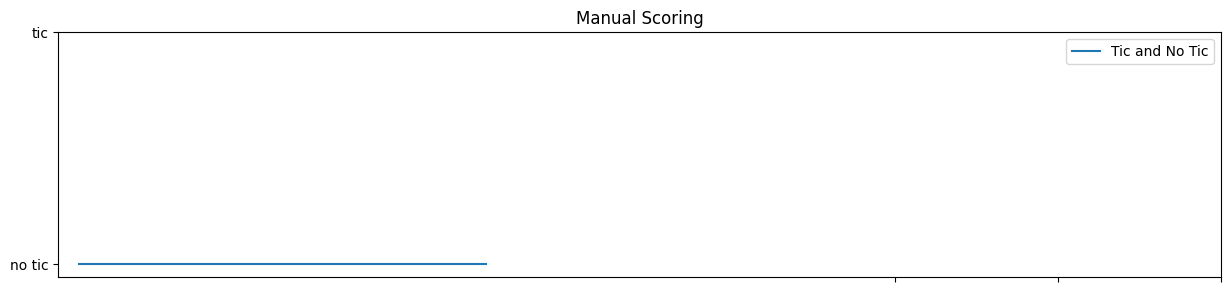

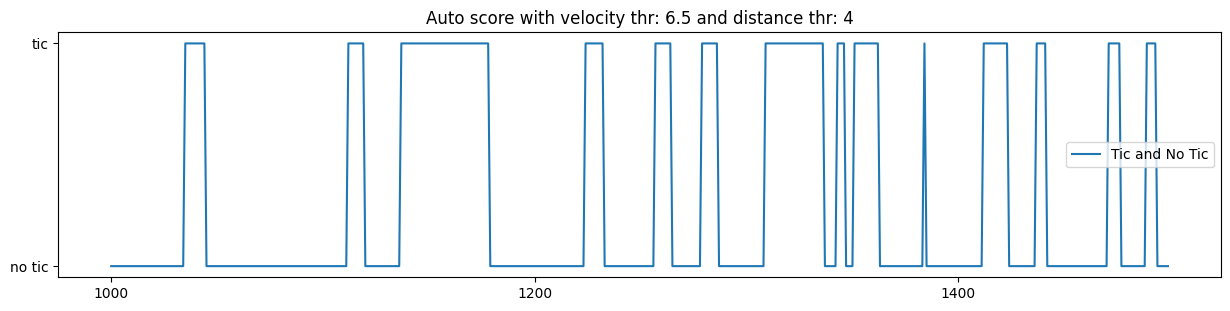

       frame      x-nose      y-nose     x-right     y-right      x-left  \
0          0  588.345825  212.669891  560.435425  257.356201  600.481445   
1          1  588.330811  212.700546  560.419800  257.403992  600.478760   
2          2  588.330872  212.700638  560.419922  257.404327  600.478760   
3          3  576.374023  207.952209  560.215393  259.750427  597.163696   
4          4  571.884949  200.755981  552.834900  255.992279  592.573486   
...      ...         ...         ...         ...         ...         ...   
22566  22566  643.705505  292.955658  632.343140  253.045242  624.278442   
22567  22567  639.870422  308.631409  636.719604  267.908905  623.936401   
22568  22568  637.228638  316.884216  636.592102  276.196686  609.186707   
22569  22569  633.097839  327.872955  636.470032  287.839264  608.128174   
22570  22570  636.455505  333.135742  637.037598  296.153748  616.337646   

           y-left    x-center    y-center short_axis_result  velocity nose  \
0      26

In [ ]:
if __name__ == '__main__' :
    main()

#Analysis


*   compare automatic scoring vs manual scoring


*   1: count tics
*   1.1: compare between manual, automatic and perfect
*   2: plot manual vs auto as histogram in 5 bin size
*   3: substract manual from automatic
*   






In [ ]:
# #count tics

# Pred = pd.DataFrame(prediction(df, start, end, thr_vel), columns=['Automatic'])
# manual_file = manual_file

# # Create a combined dataframe
# combined_df = pd.concat([manual_file['event'], Pred], axis=1)
# combined_df = combined_df.dropna()
# combined_df

# #tics in manual scoring
# tic_count = combined_df['event'].value_counts()['tic']

# print(f"Number of 'tic' occurrences manual: {tic_count}")

# #tics in automatic scoring
# tic_count = combined_df['Automatic'].value_counts()['Tic']

# print(f"Number of 'tic' occurrences automatic: {tic_count}")

# Victor-Purpura cost Spike metrics


In [ ]:
pip install elephant

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 11.7 MB/s eta 0:00:00


In [ ]:
def prediction(df, start, end, thr_vel):

    df = df.iloc[start:end,:]

    Pred = []

    for index, row in df.iterrows():
        if (row['velocity nose'] >= thr_vel):
            Pred.append('Tic')
        else:
            Pred.append('no Tic')

    return Pred

#(row['short_axis_result'] != '[True]'):
#(row['velocity nose'] >= thr_vel):

In [ ]:
#Victor-Papura style
#with original excel files
from elephant import kernels
import pandas as pd
import quantities as pq
import elephant.spike_train_dissimilarity as std
from neo import SpikeTrain
from elephant.spike_train_dissimilarity import victor_purpura_distance

#load file for calculation
#perfect manual scoring
# Define column names

thr_vel_list = [2, 4, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10, 10.5, 11, 11.5, 12, 12.5, 13, 13.5, 14, 14.5, 15, 18, 20 ]
vic = []
start = 11000
end = 13100
def victor_distance(thr_vel):    # Read excel file and filter for start time points
    man_per = pd.DataFrame(pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Rat231_000_Perfect_Scoring.xlsx')) #perfect manual score
    man = pd.DataFrame(pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Rat231_000_Manual_Scoring.xlsx')) #normal manual score
    man=man[(man["State"]=="state start")&(man["Markings"]=="Tics")] #Boriss
    man_per=man_per[(man_per["State"]=="state start")&(man_per["Markings"]=="Tics")] #Boriss

    #get automated scores
    #paste time line in seconds to predicitons dataframe
    # start = start
    # end = end
    thr_vel = i
    Pred = pd.DataFrame(prediction(df, start, end, thr_vel), columns=['Automatic'])
    Pred['time'] = (Pred.index/25) + start/25

    #only keep the the first tic in sequence turn rest to no Tic
    # Create a mask to identify the first occurrence of 'tic' in each sequence
    mask = (Pred['Automatic'] == 'Tic') & (Pred['Automatic'].shift(1) != 'Tic')
    Pred.loc[~mask, 'Automatic'] = 'No Tic'

    if Pred['Automatic'].iloc[0] == 'Tic':
        Pred['Automatic'].iloc[0] = 'No Tic'

    # #filter for start tics time points
    Pred = Pred[(Pred["Automatic"]=="Tic")]

    start_s = int(start/25)
    end_s = int(end/25)

    # Use boolean indexing to get the rows within the specified time range
    man = man[(man["Trial_time"] >= start_s) & (man["Trial_time"] <= end_s)]
    man_per = man_per[(man_per["Trial_time"] >= start_s) & (man_per["Trial_time"] <= end_s)]

    # # #define SpikeTrains for comparison
    q = 1.0 / (10.0 * pq.s)
    st_a = SpikeTrain(man_per["Trial_time"], units='s', t_stop=1000.0)
    #st_b = SpikeTrain(man["Trial_time"], units='s', t_stop=1000.0)
    st_b = SpikeTrain(Pred['time'], units='s', t_stop=1000.0) #automatic scoring for body parts ->need to be adjusted in definition

    # # Create a rate quantity
    cost_factor = 0 / pq.s

    # # Calculate Victor-Purpura distance
    distance = std.victor_purpura_distance([st_a, st_b], cost_factor, algorithm='fast', sort=False, kernel = kernels.TriangularKernel(sigma=0.815 * pq.s))[0, 1]
    #print(f"Victor-Purpura distance {round(distance, 2)} with velocity threshold: {thr_vel}")
    print(round(distance,2))
    # Append the results to the list
    vic.append({'Threshold': thr_vel, 'Distance': round(distance, 2)})
    return

for i in thr_vel_list:
      victor_distance(i)

# Create a DataFrame from the results
df_vic = pd.DataFrame(vic)
df_vic


<ipython-input-21-fb527409bd00>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Pred['Automatic'].iloc[0] = 'No Tic'


47.66


<ipython-input-21-fb527409bd00>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Pred['Automatic'].iloc[0] = 'No Tic'


49.53


<ipython-input-21-fb527409bd00>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Pred['Automatic'].iloc[0] = 'No Tic'


36.21


<ipython-input-21-fb527409bd00>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Pred['Automatic'].iloc[0] = 'No Tic'


26.5


<ipython-input-21-fb527409bd00>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Pred['Automatic'].iloc[0] = 'No Tic'


20.78


<ipython-input-21-fb527409bd00>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Pred['Automatic'].iloc[0] = 'No Tic'


20.82
25.37
28.79
30.42
36.3
40.04
42.1
44.84
47.07
47.15
48.05
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0


,Threshold,Distance
0,2.0,47.66
1,4.0,49.53
2,5.5,36.21
3,6.0,26.50
4,6.5,20.78
5,7.0,20.82
6,7.5,25.37
7,8.0,28.79
8,8.5,30.42
9,9.0,36.30


In [ ]:
st_a

NameError: ignored

In [ ]:
man_per = pd.DataFrame(pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Rat231_000_Perfect_Scoring.xlsx')) #perfect manual score
man = pd.DataFrame(pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Rat231_000_Manual_Scoring.xlsx')) #normal manual score
man=man[(man["State"]=="state start")&(man["Markings"]=="Tics")] #Boriss
man_per=man_per[(man_per["State"]=="state start")&(man_per["Markings"]=="Tics")] #Boriss

#get automated scores
#paste time line in seconds to predicitons dataframe
# start = start
# end = end
thr_vel = i
Pred = pd.DataFrame(prediction(df, start, end, thr_vel), columns=['Automatic'])
Pred['time'] = (Pred.index/25) + start/25

#only keep the the first tic in sequence turn rest to no Tic
# Create a mask to identify the first occurrence of 'tic' in each sequence
mask = (Pred['Automatic'] == 'Tic') & (Pred['Automatic'].shift(1) != 'Tic')
Pred.loc[~mask, 'Automatic'] = 'No Tic'

if Pred['Automatic'].iloc[0] == 'Tic':
    Pred['Automatic'].iloc[0] = 'No Tic'

# #filter for start tics time points
Pred = Pred[(Pred["Automatic"]=="Tic")]

start_s = int(start/25)
end_s = int(end/25)

# Use boolean indexing to get the rows within the specified time range
man = man[(man["Trial_time"] >= start_s) & (man["Trial_time"] <= end_s)]
man_per = man_per[(man_per["Trial_time"] >= start_s) & (man_per["Trial_time"] <= end_s)]

# # #define SpikeTrains for comparison
q = 1.0 / (10.0 * pq.s)
st_a = SpikeTrain(man_per["Trial_time"], units='s', t_stop=1000.0)
#st_b = SpikeTrain(man["Trial_time"], units='s', t_stop=1000.0)
st_b = SpikeTrain(Pred['time'], units='s', t_stop=1000.0) #automatic scoring for body parts ->need to be adjusted in definition

# # Create a rate quantity
cost_factor = 0 / pq.s

# # Calculate Victor-Purpura distance
distance = std.victor_purpura_distance([st_a, st_b], cost_factor, algorithm='fast', sort=False, kernel = kernels.TriangularKernel(sigma=0.815 * pq.s))[0, 1]
#print(f"Victor-Purpura distance {round(distance, 2)} with velocity threshold: {thr_vel}")
print(round(distance,2))
st_a

In [ ]:
st_1 = [1,20,30,40,50]
st_2 = [1+3,20+3,30+3,40+3,50+3, 51, 52, 53, 54]

# # #define SpikeTrains for comparison
q = 1.0 / (10.0 * pq.s)
st_a = SpikeTrain(st_1, units='s', t_stop=1000.0)
#st_b = SpikeTrain(man["Trial_time"], units='s', t_stop=1000.0)
st_b = SpikeTrain(st_2, units='s', t_stop=1000.0) #automatic scoring for body parts ->need to be adjusted in definition

# # Create a rate quantity
cost_factor = 0 / pq.s

distance = std.victor_purpura_distance([st_a, st_b], cost_factor, algorithm='fast', sort=False, kernel = kernels.TriangularKernel(sigma=0.815 * pq.s))[0, 1]
#print(f"Victor-Purpura distance {round(distance, 2)} with velocity threshold: {thr_vel}")
print(round(distance,2))

In [ ]:

# Plot the results
import matplotlib.pyplot as plt
# Plot the results
plt.plot(df_vic['Threshold'], df_vic['Distance'], label='Victor-Purpura Distance')
#plt.axhline(y = st_a.t_stop.magnitude, color='red', linestyle='--', label='st_a')
plt.xlabel('Threshold')
plt.ylabel('Victor-Purpura Distance')
plt.title('Victor-Purpura Distance vs. Threshold')
#plt.gca().invert_yaxis()  # Invert y-axis
plt.legend()
plt.show()

In [ ]:
#st_a
st_b
#man["Trial_time"]
man_per["Trial_time"]

Pred

In [ ]:
man = pd.DataFrame(pd.read_csv('/content/merged_df_1107.csv', sep=',', names=column_names)) #normal manual score
man=man[(man["State"]=="state start")&(man["Markings"]=="Tics")]
man.head(100)

In [ ]:
# gather the manual score file and the automatic for Histogram
Pred = pd.DataFrame(prediction(df, start, end, thr_vel), columns=['Automatic'])
manual_file = manual_file

# Create a combined dataframe for plotting
combined_df = pd.concat([manual_file['event'], Pred], axis=1)
combined_df = combined_df.dropna()
combined_df
#Create a histogram
plt.hist([combined_df['event'], combined_df['Automatic']], bins=range(0, len(combined_df) + 5, 5), alpha=0.7, label=['Manual', 'Automatic'])

# Set labels and title
plt.xlabel('Frames')
plt.ylabel('Frequency')
plt.title('Comparison of Manual vs Automatic Tic Detection')
plt.legend()

# Show the plot
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Count occurrences of "tic" and "no tic" for each dataframe
count_data = combined_df.groupby(['event', 'Automatic']).size().unstack().fillna(0)

# Create a grouped bar plot
plt.figure(figsize=(10, 6))
count_data.plot(kind='bar', stacked=True)
plt.xlabel('Dataframe')
plt.ylabel('Count')
plt.title('Occurrences of Tic and No Tic')
plt.xticks(rotation=0)
plt.legend(title='Tic Status')
plt.show()